# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import sys
import os
import logging

import optuna

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_absolute_error, mean_squared_error

from typing import Optional

sys.path.append("../../src")

import embedder
import models
import utils
import dataset

# Data

We should firstly parse the sample basic block data, or load it from pickle if the parsed data have been saved.
The preprocessing steps are based on data analysis done in the data exploration notebook

In [8]:
data_files = os.listdir("../../dataset/bb_data/")

if "energy_dataset.pkl" not in data_files:
    result_files = [f for f in os.listdir("../../../energy_dataset/") if f.endswith("results")] 
    data_df = pd.DataFrame()

    for file in result_files:
        file_df = utils.read_bb_data(f"../../../energy_dataset/{file}/breaker_code.txt", f"../../../energy_dataset/{file}/breaker_final_energy.txt")
        file_df = utils.preprocess_bb_df(file_df)
        data_df = pd.concat([data_df, file_df], ignore_index=True)

    data_df["bb_embeddings"] = data_df.bb.apply(lambda x: embedder.encode(x))
    data_df.to_pickle("../../dataset/bb_data/energy_dataset.pkl")
    
else:
    data_df = pd.read_pickle("../../dataset/bb_data/energy_dataset.pkl")
    if "bb_embeddings" not in data_df.columns:
        data_df["bb_embeddings"] = data_df.bb.apply(lambda x: embedder.encode(x))
        data_df.to_pickle("../../dataset/bb_data/energy_dataset.pkl")

In [9]:
data_df.head(5)

,bb,energy,bb_embeddings
0,[movl $0x0],0.645165,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
1,"[callq, pushq %rbp, mov %rsp %rbp]",2.910575,"[[0.11681142, -0.7584041, 2.0799158, 0.3227231..."
2,"[popq %rbp, retq]",0.997157,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."
3,[movl $0x0],0.664772,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
4,"[cmpl $0x64, jnl 0x2c]",1.400952,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."


Pytorch custom dataset

In [4]:
def get_data_dict(
    data_df: pd.DataFrame,
    split: float = 0.9,
    mean: bool = False,
    batch_size: int = 32,
    random_state: Optional[int] = None,
) -> dict:

    split = 0.9
    data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    bb_df_train = data_df[: int(split * len(data_df))]
    bb_df_val = data_df[int(split * len(data_df)) :]

    train_data = dataset.EnergyPredictionDataset(bb_df_train, mean=mean)
    if mean:
        train_loader = DataLoader(
            train_data, batch_size=batch_size, shuffle=False, drop_last=True
        )
    else:
        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True,
            collate_fn=utils.collate_fn,
        )

    val_data = dataset.EnergyPredictionDataset(bb_df_val, mean=mean)
    if mean:
        val_loader = DataLoader(
            val_data, batch_size=batch_size, shuffle=False, drop_last=True
        )
    else:
        val_loader = DataLoader(
            val_data,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True,
            collate_fn=utils.collate_fn,
        )

    data_loaders = {
        "train_loader": train_loader,
        "val_loader": val_loader,
    }

    return data_loaders

In [7]:
class EarlyStopper:
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss: float):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# LSTM Model

In [8]:
class LSTM_Regressor(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        hidden_size: int = 16,
        num_layers: int = 2,
        dense_size: int = 128,
        smaller_dense_size: int = 16,
        lstm_dropout: float = 0.1,
        dense_dropout: float = 0.1,
    ) -> None:
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        if self.num_layers > 1:
            lstm_dropout = lstm_dropout
        else:
            lstm_dropout = 0

        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=lstm_dropout,
        )

        self.dense = nn.Linear(hidden_size, dense_size)
        self.dropout = nn.Dropout(dense_dropout)
        self.smaller_dense_size = nn.Linear(dense_size, smaller_dense_size)
        self.regressor = nn.Linear(smaller_dense_size, 1)

    def forward(self, x, hidden):

        batch_size = x.size(0)

        lstm_out, hidden_state = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        out = self.dense(lstm_out)
        out = self.dropout(out)
        out = self.smaller_dense_size(out)
        out = self.regressor(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden_state

    def init_hidden(self, batch_size):

        hidden = (
            torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
            torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
        )

        return hidden

## Training Function

In [9]:
def train_lstm_model(
    model: LSTM_Regressor,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float = 1e-2,
    batch_size: int = 32,
    epochs: int = 100,
    verbose: bool = False,
    early_stopping: bool = True,
    lr_decay: float=0.1,
    lr_decay_step: int=10,
) -> dict:

    if early_stopping:
        early_stopper = EarlyStopper(patience=15, min_delta=1e-4)

    criterion = nn.RMSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=lr_decay_step, gamma=lr_decay)

    model.cuda()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        hidden_state = model.init_hidden(batch_size=batch_size)
        losses = []
        for embeddings, _, labels in train_loader:

            embeddings = embeddings.cuda()
            labels = labels.cuda()

            hidden_state = tuple([each.data for each in hidden_state])

            output, hidden_state = model(embeddings, hidden_state)
            #We use RRMSE Loss
            loss = torch.sqrt(criterion(output.squeeze(), labels.float()) + 1e-8)

            optimizer.zero_grad()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            losses.append(loss.item())

        val_h = model.init_hidden(batch_size)
        val_loss = []
        model.eval()
        for embeddings, _, labels in val_loader:

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history

            embeddings, labels = embeddings.cuda(), labels.cuda()
            output, val_h = model(embeddings, val_h)
            #We use RRMSE Loss
            v_loss = torch.sqrt(criterion(output.squeeze(), labels.float()) + 1e-8)

            val_loss.append(v_loss.item())

        if verbose:
            print(
                f"Epoch: {epoch+1}/{epochs}, RMSE Train Loss: {round(np.mean(losses), 5)}, RMSE Val Loss: {round(np.mean(val_loss), 5)}"
            )

        train_losses.append(np.mean(losses))
        val_losses.append(np.mean(val_loss))

        if early_stopping:
            if early_stopper.early_stop(val_losses[-1]):
                break
        
        scheduler.step()
        
    model_training = {
        "model": model,
        "train_loss": train_losses,
        "val_loss": val_losses,
        "epochs_trained": epoch,
    }

    return model_training


## Optuna Trials

In [10]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-regression-study-good-dataset"
storage_name = f"sqlite:////Users/thodo/Documents/σχολη/diplomatiki/optuna-studies/lstm-regression-study-good-dataset.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RRMSE")

[I 2023-01-11 17:07:09,988] Using an existing study with name 'lstm-regression-study-good-dataset' instead of creating a new one.


Using an existing study with name 'lstm-regression-study-good-dataset' instead of creating a new one.


In [11]:
def objective(trial):
    
    lstm_layers = trial.suggest_int("lstm_layers", 1, 5)
    hidden_size = trial.suggest_int("hidden_size", 8, 128)
    dense_size = trial.suggest_int("dense_size", 16, 256)
    smaller_dense_size = trial.suggest_int("smaller_dense_size", 8, 64)
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
    dense_dropout = trial.suggest_float("dense_dropout", 0, 0.2)
    lr_decay = trial.suggest_float("lr_decay", 0.05, 0.8)
    lr_decay_step = trial.suggest_int("lr_decay_step", 5, 20)

    batch_size = 2**batch_size_exp

    data_loaders = get_data_dict(data_df=data_df, mean=False, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = LSTM_Regressor(
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
        smaller_dense_size=smaller_dense_size,
        lstm_dropout=lstm_dropout,
        dense_dropout=dense_dropout,
    )
    train_results = train_lstm_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
        lr_decay=lr_decay,
        lr_decay_step=lr_decay_step,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]

study.optimize(objective, n_trials=120)

[I 2023-01-11 17:12:55,295] Trial 32 finished with value: 0.21337113836232355 and parameters: {'lstm_layers': 1, 'hidden_size': 93, 'dense_size': 16, 'smaller_dense_size': 52, 'lstm_dropout': 0.11909909663898159, 'dense_dropout': 0.18111995843881262, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 32 finished with value: 0.21337113836232355 and parameters: {'lstm_layers': 1, 'hidden_size': 93, 'dense_size': 16, 'smaller_dense_size': 52, 'lstm_dropout': 0.11909909663898159, 'dense_dropout': 0.18111995843881262, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 17:18:40,229] Trial 33 finished with value: 0.29636003066073446 and parameters: {'lstm_layers': 1, 'hidden_size': 92, 'dense_size': 33, 'smaller_dense_size': 51, 'lstm_dropout': 0.11209963768681745, 'dense_dropout': 0.1800234188414408, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 33 finished with value: 0.29636003066073446 and parameters: {'lstm_layers': 1, 'hidden_size': 92, 'dense_size': 33, 'smaller_dense_size': 51, 'lstm_dropout': 0.11209963768681745, 'dense_dropout': 0.1800234188414408, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 17:22:05,211] Trial 34 finished with value: 0.31354569249293385 and parameters: {'lstm_layers': 1, 'hidden_size': 79, 'dense_size': 16, 'smaller_dense_size': 55, 'lstm_dropout': 0.11471579455371783, 'dense_dropout': 0.15500888162632126, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 34 finished with value: 0.31354569249293385 and parameters: {'lstm_layers': 1, 'hidden_size': 79, 'dense_size': 16, 'smaller_dense_size': 55, 'lstm_dropout': 0.11471579455371783, 'dense_dropout': 0.15500888162632126, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 17:30:15,733] Trial 35 finished with value: 0.27077956158010397 and parameters: {'lstm_layers': 3, 'hidden_size': 102, 'dense_size': 53, 'smaller_dense_size': 60, 'lstm_dropout': 0.09421058901520478, 'dense_dropout': 0.1542022777151586, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 35 finished with value: 0.27077956158010397 and parameters: {'lstm_layers': 3, 'hidden_size': 102, 'dense_size': 53, 'smaller_dense_size': 60, 'lstm_dropout': 0.09421058901520478, 'dense_dropout': 0.1542022777151586, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 17:34:21,008] Trial 36 finished with value: 0.2560680867994533 and parameters: {'lstm_layers': 2, 'hidden_size': 86, 'dense_size': 32, 'smaller_dense_size': 50, 'lstm_dropout': 0.13684462829799693, 'dense_dropout': 0.1855763436064355, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 36 finished with value: 0.2560680867994533 and parameters: {'lstm_layers': 2, 'hidden_size': 86, 'dense_size': 32, 'smaller_dense_size': 50, 'lstm_dropout': 0.13684462829799693, 'dense_dropout': 0.1855763436064355, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 17:45:18,889] Trial 37 finished with value: 0.34123300296672876 and parameters: {'lstm_layers': 1, 'hidden_size': 73, 'dense_size': 53, 'smaller_dense_size': 9, 'lstm_dropout': 0.11242033793405955, 'dense_dropout': 0.16169862775090643, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 37 finished with value: 0.34123300296672876 and parameters: {'lstm_layers': 1, 'hidden_size': 73, 'dense_size': 53, 'smaller_dense_size': 9, 'lstm_dropout': 0.11242033793405955, 'dense_dropout': 0.16169862775090643, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 17:49:19,510] Trial 38 finished with value: 0.24543867961448781 and parameters: {'lstm_layers': 2, 'hidden_size': 116, 'dense_size': 36, 'smaller_dense_size': 13, 'lstm_dropout': 0.13831489258910976, 'dense_dropout': 0.17823610099398657, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 38 finished with value: 0.24543867961448781 and parameters: {'lstm_layers': 2, 'hidden_size': 116, 'dense_size': 36, 'smaller_dense_size': 13, 'lstm_dropout': 0.13831489258910976, 'dense_dropout': 0.17823610099398657, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 17:57:16,423] Trial 39 finished with value: 0.2282278621021439 and parameters: {'lstm_layers': 3, 'hidden_size': 108, 'dense_size': 22, 'smaller_dense_size': 54, 'lstm_dropout': 0.0840118114572441, 'dense_dropout': 0.19046671465124887, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 39 finished with value: 0.2282278621021439 and parameters: {'lstm_layers': 3, 'hidden_size': 108, 'dense_size': 22, 'smaller_dense_size': 54, 'lstm_dropout': 0.0840118114572441, 'dense_dropout': 0.19046671465124887, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 18:11:02,100] Trial 40 finished with value: 0.3680569957131925 and parameters: {'lstm_layers': 2, 'hidden_size': 109, 'dense_size': 21, 'smaller_dense_size': 61, 'lstm_dropout': 0.0753834656234898, 'dense_dropout': 0.1993115604735171, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 40 finished with value: 0.3680569957131925 and parameters: {'lstm_layers': 2, 'hidden_size': 109, 'dense_size': 21, 'smaller_dense_size': 61, 'lstm_dropout': 0.0753834656234898, 'dense_dropout': 0.1993115604735171, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 18:19:24,581] Trial 41 finished with value: 0.29574974045595703 and parameters: {'lstm_layers': 3, 'hidden_size': 84, 'dense_size': 42, 'smaller_dense_size': 53, 'lstm_dropout': 0.056028834161253815, 'dense_dropout': 0.17083088967270055, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 41 finished with value: 0.29574974045595703 and parameters: {'lstm_layers': 3, 'hidden_size': 84, 'dense_size': 42, 'smaller_dense_size': 53, 'lstm_dropout': 0.056028834161253815, 'dense_dropout': 0.17083088967270055, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 18:48:37,782] Trial 42 finished with value: 0.24791035184087298 and parameters: {'lstm_layers': 3, 'hidden_size': 93, 'dense_size': 29, 'smaller_dense_size': 55, 'lstm_dropout': 0.09863524220840231, 'dense_dropout': 0.09211978429202898, 'batch_size_exp': 4, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 42 finished with value: 0.24791035184087298 and parameters: {'lstm_layers': 3, 'hidden_size': 93, 'dense_size': 29, 'smaller_dense_size': 55, 'lstm_dropout': 0.09863524220840231, 'dense_dropout': 0.09211978429202898, 'batch_size_exp': 4, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 18:57:33,583] Trial 43 finished with value: 0.3302144131020588 and parameters: {'lstm_layers': 4, 'hidden_size': 101, 'dense_size': 63, 'smaller_dense_size': 50, 'lstm_dropout': 0.1201564347007582, 'dense_dropout': 0.18844484365261338, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 43 finished with value: 0.3302144131020588 and parameters: {'lstm_layers': 4, 'hidden_size': 101, 'dense_size': 63, 'smaller_dense_size': 50, 'lstm_dropout': 0.1201564347007582, 'dense_dropout': 0.18844484365261338, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 19:05:12,808] Trial 44 finished with value: 0.29441995283260064 and parameters: {'lstm_layers': 3, 'hidden_size': 110, 'dense_size': 25, 'smaller_dense_size': 41, 'lstm_dropout': 0.08150587369421342, 'dense_dropout': 0.19228621022777087, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 44 finished with value: 0.29441995283260064 and parameters: {'lstm_layers': 3, 'hidden_size': 110, 'dense_size': 25, 'smaller_dense_size': 41, 'lstm_dropout': 0.08150587369421342, 'dense_dropout': 0.19228621022777087, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 19:08:52,962] Trial 45 finished with value: 0.2916075205978225 and parameters: {'lstm_layers': 2, 'hidden_size': 96, 'dense_size': 40, 'smaller_dense_size': 58, 'lstm_dropout': 0.13296449213363773, 'dense_dropout': 0.18104148379891438, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 45 finished with value: 0.2916075205978225 and parameters: {'lstm_layers': 2, 'hidden_size': 96, 'dense_size': 40, 'smaller_dense_size': 58, 'lstm_dropout': 0.13296449213363773, 'dense_dropout': 0.18104148379891438, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 19:13:45,270] Trial 46 finished with value: 0.24299858685802012 and parameters: {'lstm_layers': 4, 'hidden_size': 125, 'dense_size': 58, 'smaller_dense_size': 47, 'lstm_dropout': 0.10540107266919822, 'dense_dropout': 0.1595038283959547, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 46 finished with value: 0.24299858685802012 and parameters: {'lstm_layers': 4, 'hidden_size': 125, 'dense_size': 58, 'smaller_dense_size': 47, 'lstm_dropout': 0.10540107266919822, 'dense_dropout': 0.1595038283959547, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 19:21:10,425] Trial 47 finished with value: 0.3196763028116787 and parameters: {'lstm_layers': 3, 'hidden_size': 88, 'dense_size': 18, 'smaller_dense_size': 63, 'lstm_dropout': 0.0654587621053574, 'dense_dropout': 0.17478955898002224, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 47 finished with value: 0.3196763028116787 and parameters: {'lstm_layers': 3, 'hidden_size': 88, 'dense_size': 18, 'smaller_dense_size': 63, 'lstm_dropout': 0.0654587621053574, 'dense_dropout': 0.17478955898002224, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 19:30:03,602] Trial 48 finished with value: 0.3240773217643009 and parameters: {'lstm_layers': 4, 'hidden_size': 83, 'dense_size': 40, 'smaller_dense_size': 53, 'lstm_dropout': 0.1449530065767326, 'dense_dropout': 0.1902064278871447, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 48 finished with value: 0.3240773217643009 and parameters: {'lstm_layers': 4, 'hidden_size': 83, 'dense_size': 40, 'smaller_dense_size': 53, 'lstm_dropout': 0.1449530065767326, 'dense_dropout': 0.1902064278871447, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 20:32:14,627] Trial 49 finished with value: 0.3215731453053707 and parameters: {'lstm_layers': 5, 'hidden_size': 104, 'dense_size': 28, 'smaller_dense_size': 58, 'lstm_dropout': 0.15626934390753902, 'dense_dropout': 0.1471292696084557, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 32 with value: 0.21337113836232355.


Trial 49 finished with value: 0.3215731453053707 and parameters: {'lstm_layers': 5, 'hidden_size': 104, 'dense_size': 28, 'smaller_dense_size': 58, 'lstm_dropout': 0.15626934390753902, 'dense_dropout': 0.1471292696084557, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 20:35:26,443] Trial 50 finished with value: 0.2869332634350833 and parameters: {'lstm_layers': 1, 'hidden_size': 113, 'dense_size': 80, 'smaller_dense_size': 21, 'lstm_dropout': 0.040174797750224416, 'dense_dropout': 0.1282901578719814, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 50 finished with value: 0.2869332634350833 and parameters: {'lstm_layers': 1, 'hidden_size': 113, 'dense_size': 80, 'smaller_dense_size': 21, 'lstm_dropout': 0.040174797750224416, 'dense_dropout': 0.1282901578719814, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 20:39:43,739] Trial 51 finished with value: 0.25283634180531783 and parameters: {'lstm_layers': 3, 'hidden_size': 93, 'dense_size': 48, 'smaller_dense_size': 48, 'lstm_dropout': 0.10707643013410972, 'dense_dropout': 0.17299835524181342, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 51 finished with value: 0.25283634180531783 and parameters: {'lstm_layers': 3, 'hidden_size': 93, 'dense_size': 48, 'smaller_dense_size': 48, 'lstm_dropout': 0.10707643013410972, 'dense_dropout': 0.17299835524181342, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 20:59:04,172] Trial 52 finished with value: 0.2786480137619419 and parameters: {'lstm_layers': 5, 'hidden_size': 74, 'dense_size': 80, 'smaller_dense_size': 42, 'lstm_dropout': 0.09014759768364934, 'dense_dropout': 0.06582019334436057, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 52 finished with value: 0.2786480137619419 and parameters: {'lstm_layers': 5, 'hidden_size': 74, 'dense_size': 80, 'smaller_dense_size': 42, 'lstm_dropout': 0.09014759768364934, 'dense_dropout': 0.06582019334436057, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 21:03:52,600] Trial 53 finished with value: 0.32860806759665995 and parameters: {'lstm_layers': 4, 'hidden_size': 128, 'dense_size': 57, 'smaller_dense_size': 48, 'lstm_dropout': 0.12994766109456726, 'dense_dropout': 0.1588561060939724, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 53 finished with value: 0.32860806759665995 and parameters: {'lstm_layers': 4, 'hidden_size': 128, 'dense_size': 57, 'smaller_dense_size': 48, 'lstm_dropout': 0.12994766109456726, 'dense_dropout': 0.1588561060939724, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 21:08:40,075] Trial 54 finished with value: 0.3230460290523136 and parameters: {'lstm_layers': 4, 'hidden_size': 119, 'dense_size': 16, 'smaller_dense_size': 47, 'lstm_dropout': 0.10623486701715751, 'dense_dropout': 0.16812982346550992, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 54 finished with value: 0.3230460290523136 and parameters: {'lstm_layers': 4, 'hidden_size': 119, 'dense_size': 16, 'smaller_dense_size': 47, 'lstm_dropout': 0.10623486701715751, 'dense_dropout': 0.16812982346550992, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 21:13:29,039] Trial 55 finished with value: 0.26950424296014447 and parameters: {'lstm_layers': 4, 'hidden_size': 124, 'dense_size': 30, 'smaller_dense_size': 56, 'lstm_dropout': 0.11974947858119854, 'dense_dropout': 0.19344606647899787, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 55 finished with value: 0.26950424296014447 and parameters: {'lstm_layers': 4, 'hidden_size': 124, 'dense_size': 30, 'smaller_dense_size': 56, 'lstm_dropout': 0.11974947858119854, 'dense_dropout': 0.19344606647899787, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 21:22:11,782] Trial 56 finished with value: 0.2293597410487778 and parameters: {'lstm_layers': 4, 'hidden_size': 123, 'dense_size': 44, 'smaller_dense_size': 36, 'lstm_dropout': 0.09763930703481544, 'dense_dropout': 0.16419072835372814, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 56 finished with value: 0.2293597410487778 and parameters: {'lstm_layers': 4, 'hidden_size': 123, 'dense_size': 44, 'smaller_dense_size': 36, 'lstm_dropout': 0.09763930703481544, 'dense_dropout': 0.16419072835372814, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 21:30:58,754] Trial 57 finished with value: 0.2940933152156718 and parameters: {'lstm_layers': 4, 'hidden_size': 97, 'dense_size': 39, 'smaller_dense_size': 36, 'lstm_dropout': 0.07465968446936563, 'dense_dropout': 0.04044323674764183, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 57 finished with value: 0.2940933152156718 and parameters: {'lstm_layers': 4, 'hidden_size': 97, 'dense_size': 39, 'smaller_dense_size': 36, 'lstm_dropout': 0.07465968446936563, 'dense_dropout': 0.04044323674764183, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 21:38:36,359] Trial 58 finished with value: 0.24374412701410406 and parameters: {'lstm_layers': 3, 'hidden_size': 122, 'dense_size': 26, 'smaller_dense_size': 27, 'lstm_dropout': 0.09967208105577882, 'dense_dropout': 0.14867594378259902, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 58 finished with value: 0.24374412701410406 and parameters: {'lstm_layers': 3, 'hidden_size': 122, 'dense_size': 26, 'smaller_dense_size': 27, 'lstm_dropout': 0.09967208105577882, 'dense_dropout': 0.14867594378259902, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 21:57:50,224] Trial 59 finished with value: 0.234743251087333 and parameters: {'lstm_layers': 5, 'hidden_size': 113, 'dense_size': 47, 'smaller_dense_size': 17, 'lstm_dropout': 0.16481370236826953, 'dense_dropout': 0.16656913289841396, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 59 finished with value: 0.234743251087333 and parameters: {'lstm_layers': 5, 'hidden_size': 113, 'dense_size': 47, 'smaller_dense_size': 17, 'lstm_dropout': 0.16481370236826953, 'dense_dropout': 0.16656913289841396, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 22:17:00,927] Trial 60 finished with value: 0.2704986936102311 and parameters: {'lstm_layers': 5, 'hidden_size': 113, 'dense_size': 43, 'smaller_dense_size': 17, 'lstm_dropout': 0.1861890619091057, 'dense_dropout': 0.16368621087728508, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 60 finished with value: 0.2704986936102311 and parameters: {'lstm_layers': 5, 'hidden_size': 113, 'dense_size': 43, 'smaller_dense_size': 17, 'lstm_dropout': 0.1861890619091057, 'dense_dropout': 0.16368621087728508, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 22:36:15,807] Trial 61 finished with value: 0.3216272039149982 and parameters: {'lstm_layers': 5, 'hidden_size': 105, 'dense_size': 104, 'smaller_dense_size': 15, 'lstm_dropout': 0.1628235937360239, 'dense_dropout': 0.1364162142179647, 'batch_size_exp': 5, 'learning_rate_exp': -3}. Best is trial 32 with value: 0.21337113836232355.


Trial 61 finished with value: 0.3216272039149982 and parameters: {'lstm_layers': 5, 'hidden_size': 105, 'dense_size': 104, 'smaller_dense_size': 15, 'lstm_dropout': 0.1628235937360239, 'dense_dropout': 0.1364162142179647, 'batch_size_exp': 5, 'learning_rate_exp': -3}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 23:00:07,954] Trial 62 finished with value: 0.41668052864830485 and parameters: {'lstm_layers': 2, 'hidden_size': 112, 'dense_size': 182, 'smaller_dense_size': 12, 'lstm_dropout': 0.1747713531956665, 'dense_dropout': 0.17796277843934283, 'batch_size_exp': 4, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 62 finished with value: 0.41668052864830485 and parameters: {'lstm_layers': 2, 'hidden_size': 112, 'dense_size': 182, 'smaller_dense_size': 12, 'lstm_dropout': 0.1747713531956665, 'dense_dropout': 0.17796277843934283, 'batch_size_exp': 4, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 23:08:54,487] Trial 63 finished with value: 0.2838246508994523 and parameters: {'lstm_layers': 4, 'hidden_size': 98, 'dense_size': 64, 'smaller_dense_size': 23, 'lstm_dropout': 0.18512322036632692, 'dense_dropout': 0.18296023495310973, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 63 finished with value: 0.2838246508994523 and parameters: {'lstm_layers': 4, 'hidden_size': 98, 'dense_size': 64, 'smaller_dense_size': 23, 'lstm_dropout': 0.18512322036632692, 'dense_dropout': 0.18296023495310973, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 23:27:59,420] Trial 64 finished with value: 0.35778231260137283 and parameters: {'lstm_layers': 5, 'hidden_size': 106, 'dense_size': 24, 'smaller_dense_size': 20, 'lstm_dropout': 0.19300468068443383, 'dense_dropout': 0.167611972493904, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 64 finished with value: 0.35778231260137283 and parameters: {'lstm_layers': 5, 'hidden_size': 106, 'dense_size': 24, 'smaller_dense_size': 20, 'lstm_dropout': 0.19300468068443383, 'dense_dropout': 0.167611972493904, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 23:35:33,525] Trial 65 finished with value: 0.27835051452412324 and parameters: {'lstm_layers': 3, 'hidden_size': 92, 'dense_size': 48, 'smaller_dense_size': 52, 'lstm_dropout': 0.1437844630474172, 'dense_dropout': 0.19388204014014804, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 65 finished with value: 0.27835051452412324 and parameters: {'lstm_layers': 3, 'hidden_size': 92, 'dense_size': 48, 'smaller_dense_size': 52, 'lstm_dropout': 0.1437844630474172, 'dense_dropout': 0.19388204014014804, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-11 23:52:24,534] Trial 66 finished with value: 0.3330082348615363 and parameters: {'lstm_layers': 4, 'hidden_size': 116, 'dense_size': 34, 'smaller_dense_size': 32, 'lstm_dropout': 0.17066534924787943, 'dense_dropout': 0.18523607443488174, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 66 finished with value: 0.3330082348615363 and parameters: {'lstm_layers': 4, 'hidden_size': 116, 'dense_size': 34, 'smaller_dense_size': 32, 'lstm_dropout': 0.17066534924787943, 'dense_dropout': 0.18523607443488174, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 00:02:16,114] Trial 67 finished with value: 0.32746152097688 and parameters: {'lstm_layers': 5, 'hidden_size': 70, 'dense_size': 73, 'smaller_dense_size': 25, 'lstm_dropout': 0.15139788954560762, 'dense_dropout': 0.17604214730935444, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 67 finished with value: 0.32746152097688 and parameters: {'lstm_layers': 5, 'hidden_size': 70, 'dense_size': 73, 'smaller_dense_size': 25, 'lstm_dropout': 0.15139788954560762, 'dense_dropout': 0.17604214730935444, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 00:10:58,918] Trial 68 finished with value: 0.3316787629223922 and parameters: {'lstm_layers': 4, 'hidden_size': 65, 'dense_size': 24, 'smaller_dense_size': 18, 'lstm_dropout': 0.0839936298263795, 'dense_dropout': 0.15110977230130038, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 68 finished with value: 0.3316787629223922 and parameters: {'lstm_layers': 4, 'hidden_size': 65, 'dense_size': 24, 'smaller_dense_size': 18, 'lstm_dropout': 0.0839936298263795, 'dense_dropout': 0.15110977230130038, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 00:39:28,485] Trial 69 finished with value: 0.30900453147645907 and parameters: {'lstm_layers': 3, 'hidden_size': 59, 'dense_size': 91, 'smaller_dense_size': 11, 'lstm_dropout': 0.12230607147817822, 'dense_dropout': 0.1942456743649601, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 32 with value: 0.21337113836232355.


Trial 69 finished with value: 0.30900453147645907 and parameters: {'lstm_layers': 3, 'hidden_size': 59, 'dense_size': 91, 'smaller_dense_size': 11, 'lstm_dropout': 0.12230607147817822, 'dense_dropout': 0.1942456743649601, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 00:51:46,753] Trial 70 finished with value: 0.24948284888397093 and parameters: {'lstm_layers': 2, 'hidden_size': 80, 'dense_size': 143, 'smaller_dense_size': 8, 'lstm_dropout': 0.09330305314633403, 'dense_dropout': 0.16467753162581414, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 70 finished with value: 0.24948284888397093 and parameters: {'lstm_layers': 2, 'hidden_size': 80, 'dense_size': 143, 'smaller_dense_size': 8, 'lstm_dropout': 0.09330305314633403, 'dense_dropout': 0.16467753162581414, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 01:01:37,632] Trial 71 finished with value: 0.28082327205030355 and parameters: {'lstm_layers': 5, 'hidden_size': 120, 'dense_size': 16, 'smaller_dense_size': 14, 'lstm_dropout': 0.11682708938601391, 'dense_dropout': 0.19939300093709986, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 71 finished with value: 0.28082327205030355 and parameters: {'lstm_layers': 5, 'hidden_size': 120, 'dense_size': 16, 'smaller_dense_size': 14, 'lstm_dropout': 0.11682708938601391, 'dense_dropout': 0.19939300093709986, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 01:16:09,481] Trial 72 finished with value: 0.2471281737629054 and parameters: {'lstm_layers': 3, 'hidden_size': 107, 'dense_size': 53, 'smaller_dense_size': 56, 'lstm_dropout': 0.1288271878736032, 'dense_dropout': 0.1855588791230345, 'batch_size_exp': 5, 'learning_rate_exp': -4}. Best is trial 32 with value: 0.21337113836232355.


Trial 72 finished with value: 0.2471281737629054 and parameters: {'lstm_layers': 3, 'hidden_size': 107, 'dense_size': 53, 'smaller_dense_size': 56, 'lstm_dropout': 0.1288271878736032, 'dense_dropout': 0.1855588791230345, 'batch_size_exp': 5, 'learning_rate_exp': -4}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 01:21:03,175] Trial 73 finished with value: 0.2503717287498362 and parameters: {'lstm_layers': 4, 'hidden_size': 122, 'dense_size': 60, 'smaller_dense_size': 43, 'lstm_dropout': 0.10681650284364239, 'dense_dropout': 0.15833338948393774, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 73 finished with value: 0.2503717287498362 and parameters: {'lstm_layers': 4, 'hidden_size': 122, 'dense_size': 60, 'smaller_dense_size': 43, 'lstm_dropout': 0.10681650284364239, 'dense_dropout': 0.15833338948393774, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 01:25:53,292] Trial 74 finished with value: 0.30824047677657185 and parameters: {'lstm_layers': 4, 'hidden_size': 125, 'dense_size': 33, 'smaller_dense_size': 50, 'lstm_dropout': 0.09865285325878356, 'dense_dropout': 0.14349794314588452, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


Trial 74 finished with value: 0.30824047677657185 and parameters: {'lstm_layers': 4, 'hidden_size': 125, 'dense_size': 33, 'smaller_dense_size': 50, 'lstm_dropout': 0.09865285325878356, 'dense_dropout': 0.14349794314588452, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 32 with value: 0.21337113836232355.


[I 2023-01-12 01:30:46,542] Trial 75 finished with value: 0.19948927619877985 and parameters: {'lstm_layers': 4, 'hidden_size': 88, 'dense_size': 45, 'smaller_dense_size': 62, 'lstm_dropout': 0.11000544989835763, 'dense_dropout': 0.16872507347217458, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 75 finished with value: 0.19948927619877985 and parameters: {'lstm_layers': 4, 'hidden_size': 88, 'dense_size': 45, 'smaller_dense_size': 62, 'lstm_dropout': 0.11000544989835763, 'dense_dropout': 0.16872507347217458, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 01:35:42,390] Trial 76 finished with value: 0.27820097523577075 and parameters: {'lstm_layers': 4, 'hidden_size': 88, 'dense_size': 47, 'smaller_dense_size': 62, 'lstm_dropout': 0.11065649750842964, 'dense_dropout': 0.1702465484893889, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 76 finished with value: 0.27820097523577075 and parameters: {'lstm_layers': 4, 'hidden_size': 88, 'dense_size': 47, 'smaller_dense_size': 62, 'lstm_dropout': 0.11065649750842964, 'dense_dropout': 0.1702465484893889, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 01:44:31,593] Trial 77 finished with value: 0.22555633371367173 and parameters: {'lstm_layers': 4, 'hidden_size': 78, 'dense_size': 24, 'smaller_dense_size': 59, 'lstm_dropout': 0.18059001441111788, 'dense_dropout': 0.17894442886800824, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 77 finished with value: 0.22555633371367173 and parameters: {'lstm_layers': 4, 'hidden_size': 78, 'dense_size': 24, 'smaller_dense_size': 59, 'lstm_dropout': 0.18059001441111788, 'dense_dropout': 0.17894442886800824, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 01:53:17,758] Trial 78 finished with value: 0.34138360729112344 and parameters: {'lstm_layers': 4, 'hidden_size': 78, 'dense_size': 254, 'smaller_dense_size': 59, 'lstm_dropout': 0.1798774691737901, 'dense_dropout': 0.17893957115782191, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 78 finished with value: 0.34138360729112344 and parameters: {'lstm_layers': 4, 'hidden_size': 78, 'dense_size': 254, 'smaller_dense_size': 59, 'lstm_dropout': 0.1798774691737901, 'dense_dropout': 0.17893957115782191, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 02:00:59,385] Trial 79 finished with value: 0.2089516859063331 and parameters: {'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 23, 'smaller_dense_size': 62, 'lstm_dropout': 0.19960135761095857, 'dense_dropout': 0.17390455934631835, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 79 finished with value: 0.2089516859063331 and parameters: {'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 23, 'smaller_dense_size': 62, 'lstm_dropout': 0.19960135761095857, 'dense_dropout': 0.17390455934631835, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 02:10:55,766] Trial 80 finished with value: 0.3343178623301141 and parameters: {'lstm_layers': 5, 'hidden_size': 82, 'dense_size': 36, 'smaller_dense_size': 62, 'lstm_dropout': 0.19890600172687584, 'dense_dropout': 0.17325824169625686, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 80 finished with value: 0.3343178623301141 and parameters: {'lstm_layers': 5, 'hidden_size': 82, 'dense_size': 36, 'smaller_dense_size': 62, 'lstm_dropout': 0.19890600172687584, 'dense_dropout': 0.17325824169625686, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 02:18:29,709] Trial 81 finished with value: 0.31401252297355847 and parameters: {'lstm_layers': 3, 'hidden_size': 100, 'dense_size': 23, 'smaller_dense_size': 57, 'lstm_dropout': 0.18286496659981571, 'dense_dropout': 0.1550124857991338, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 81 finished with value: 0.31401252297355847 and parameters: {'lstm_layers': 3, 'hidden_size': 100, 'dense_size': 23, 'smaller_dense_size': 57, 'lstm_dropout': 0.18286496659981571, 'dense_dropout': 0.1550124857991338, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 02:27:15,413] Trial 82 finished with value: 0.37250229650560546 and parameters: {'lstm_layers': 4, 'hidden_size': 87, 'dense_size': 239, 'smaller_dense_size': 63, 'lstm_dropout': 0.18976197434744238, 'dense_dropout': 0.12421571745546764, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 82 finished with value: 0.37250229650560546 and parameters: {'lstm_layers': 4, 'hidden_size': 87, 'dense_size': 239, 'smaller_dense_size': 63, 'lstm_dropout': 0.18976197434744238, 'dense_dropout': 0.12421571745546764, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 02:34:51,562] Trial 83 finished with value: 0.3094208192299394 and parameters: {'lstm_layers': 3, 'hidden_size': 90, 'dense_size': 22, 'smaller_dense_size': 60, 'lstm_dropout': 0.1753700378785787, 'dense_dropout': 0.16369712122235297, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 83 finished with value: 0.3094208192299394 and parameters: {'lstm_layers': 3, 'hidden_size': 90, 'dense_size': 22, 'smaller_dense_size': 60, 'lstm_dropout': 0.1753700378785787, 'dense_dropout': 0.16369712122235297, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 02:42:29,450] Trial 84 finished with value: 0.33093227270771475 and parameters: {'lstm_layers': 3, 'hidden_size': 95, 'dense_size': 31, 'smaller_dense_size': 64, 'lstm_dropout': 0.1683398317853094, 'dense_dropout': 0.18754695222497578, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 84 finished with value: 0.33093227270771475 and parameters: {'lstm_layers': 3, 'hidden_size': 95, 'dense_size': 31, 'smaller_dense_size': 64, 'lstm_dropout': 0.1683398317853094, 'dense_dropout': 0.18754695222497578, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 02:50:09,430] Trial 85 finished with value: 0.2695267975111218 and parameters: {'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 39, 'smaller_dense_size': 61, 'lstm_dropout': 0.16017735380456588, 'dense_dropout': 0.1781009752105466, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 85 finished with value: 0.2695267975111218 and parameters: {'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 39, 'smaller_dense_size': 61, 'lstm_dropout': 0.16017735380456588, 'dense_dropout': 0.1781009752105466, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 03:04:47,461] Trial 86 finished with value: 0.3119832251922808 and parameters: {'lstm_layers': 3, 'hidden_size': 76, 'dense_size': 44, 'smaller_dense_size': 54, 'lstm_dropout': 0.19593002438076823, 'dense_dropout': 0.10578109075404282, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 86 finished with value: 0.3119832251922808 and parameters: {'lstm_layers': 3, 'hidden_size': 76, 'dense_size': 44, 'smaller_dense_size': 54, 'lstm_dropout': 0.19593002438076823, 'dense_dropout': 0.10578109075404282, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 03:10:05,035] Trial 87 finished with value: 0.2565225305802682 and parameters: {'lstm_layers': 1, 'hidden_size': 90, 'dense_size': 21, 'smaller_dense_size': 59, 'lstm_dropout': 0.19321533699790175, 'dense_dropout': 0.1692691269054292, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 87 finished with value: 0.2565225305802682 and parameters: {'lstm_layers': 1, 'hidden_size': 90, 'dense_size': 21, 'smaller_dense_size': 59, 'lstm_dropout': 0.19321533699790175, 'dense_dropout': 0.1692691269054292, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 03:18:51,229] Trial 88 finished with value: 0.27779097329167757 and parameters: {'lstm_layers': 4, 'hidden_size': 102, 'dense_size': 215, 'smaller_dense_size': 38, 'lstm_dropout': 0.07635854988666378, 'dense_dropout': 0.18121122375468773, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 88 finished with value: 0.27779097329167757 and parameters: {'lstm_layers': 4, 'hidden_size': 102, 'dense_size': 215, 'smaller_dense_size': 38, 'lstm_dropout': 0.07635854988666378, 'dense_dropout': 0.18121122375468773, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 03:26:26,056] Trial 89 finished with value: 0.27333723830387874 and parameters: {'lstm_layers': 3, 'hidden_size': 95, 'dense_size': 28, 'smaller_dense_size': 57, 'lstm_dropout': 0.18878430899574078, 'dense_dropout': 0.19124197362156561, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 89 finished with value: 0.27333723830387874 and parameters: {'lstm_layers': 3, 'hidden_size': 95, 'dense_size': 28, 'smaller_dense_size': 57, 'lstm_dropout': 0.18878430899574078, 'dense_dropout': 0.19124197362156561, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 03:38:40,079] Trial 90 finished with value: 0.2943146225820849 and parameters: {'lstm_layers': 2, 'hidden_size': 85, 'dense_size': 35, 'smaller_dense_size': 62, 'lstm_dropout': 0.17837918420691104, 'dense_dropout': 0.17302219335767835, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 90 finished with value: 0.2943146225820849 and parameters: {'lstm_layers': 2, 'hidden_size': 85, 'dense_size': 35, 'smaller_dense_size': 62, 'lstm_dropout': 0.17837918420691104, 'dense_dropout': 0.17302219335767835, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 03:42:58,250] Trial 91 finished with value: 0.3576161440681009 and parameters: {'lstm_layers': 3, 'hidden_size': 72, 'dense_size': 16, 'smaller_dense_size': 54, 'lstm_dropout': 0.08713137835794403, 'dense_dropout': 0.08575458083113563, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 91 finished with value: 0.3576161440681009 and parameters: {'lstm_layers': 3, 'hidden_size': 72, 'dense_size': 16, 'smaller_dense_size': 54, 'lstm_dropout': 0.08713137835794403, 'dense_dropout': 0.08575458083113563, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 03:51:43,923] Trial 92 finished with value: 0.2946085442295846 and parameters: {'lstm_layers': 4, 'hidden_size': 100, 'dense_size': 70, 'smaller_dense_size': 28, 'lstm_dropout': 0.05651581162788271, 'dense_dropout': 0.195266213771761, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 92 finished with value: 0.2946085442295846 and parameters: {'lstm_layers': 4, 'hidden_size': 100, 'dense_size': 70, 'smaller_dense_size': 28, 'lstm_dropout': 0.05651581162788271, 'dense_dropout': 0.195266213771761, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 03:56:37,490] Trial 93 finished with value: 0.28264963363899903 and parameters: {'lstm_layers': 4, 'hidden_size': 80, 'dense_size': 51, 'smaller_dense_size': 51, 'lstm_dropout': 0.1233588365823461, 'dense_dropout': 0.18263612851718405, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 93 finished with value: 0.28264963363899903 and parameters: {'lstm_layers': 4, 'hidden_size': 80, 'dense_size': 51, 'smaller_dense_size': 51, 'lstm_dropout': 0.1233588365823461, 'dense_dropout': 0.18263612851718405, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 04:01:29,644] Trial 94 finished with value: 0.2953181314994307 and parameters: {'lstm_layers': 4, 'hidden_size': 67, 'dense_size': 28, 'smaller_dense_size': 59, 'lstm_dropout': 0.13478999233924785, 'dense_dropout': 0.18763176355672995, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 94 finished with value: 0.2953181314994307 and parameters: {'lstm_layers': 4, 'hidden_size': 67, 'dense_size': 28, 'smaller_dense_size': 59, 'lstm_dropout': 0.13478999233924785, 'dense_dropout': 0.18763176355672995, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 04:06:22,688] Trial 95 finished with value: 0.34884998202323914 and parameters: {'lstm_layers': 4, 'hidden_size': 90, 'dense_size': 42, 'smaller_dense_size': 61, 'lstm_dropout': 0.10267166036629147, 'dense_dropout': 0.1668141166262163, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 95 finished with value: 0.34884998202323914 and parameters: {'lstm_layers': 4, 'hidden_size': 90, 'dense_size': 42, 'smaller_dense_size': 61, 'lstm_dropout': 0.10267166036629147, 'dense_dropout': 0.1668141166262163, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 04:11:14,619] Trial 96 finished with value: 0.2804507591268596 and parameters: {'lstm_layers': 4, 'hidden_size': 111, 'dense_size': 21, 'smaller_dense_size': 57, 'lstm_dropout': 0.09527439296392565, 'dense_dropout': 0.17627547032838792, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 96 finished with value: 0.2804507591268596 and parameters: {'lstm_layers': 4, 'hidden_size': 111, 'dense_size': 21, 'smaller_dense_size': 57, 'lstm_dropout': 0.09527439296392565, 'dense_dropout': 0.17627547032838792, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 04:15:32,358] Trial 97 finished with value: 0.31965283172972064 and parameters: {'lstm_layers': 3, 'hidden_size': 75, 'dense_size': 57, 'smaller_dense_size': 55, 'lstm_dropout': 0.11022231680134685, 'dense_dropout': 0.1581832226778454, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 97 finished with value: 0.31965283172972064 and parameters: {'lstm_layers': 3, 'hidden_size': 75, 'dense_size': 57, 'smaller_dense_size': 55, 'lstm_dropout': 0.11022231680134685, 'dense_dropout': 0.1581832226778454, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 04:25:23,704] Trial 98 finished with value: 0.21277994443388545 and parameters: {'lstm_layers': 5, 'hidden_size': 78, 'dense_size': 36, 'smaller_dense_size': 21, 'lstm_dropout': 0.1175801977686278, 'dense_dropout': 0.18936433782261092, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 98 finished with value: 0.21277994443388545 and parameters: {'lstm_layers': 5, 'hidden_size': 78, 'dense_size': 36, 'smaller_dense_size': 21, 'lstm_dropout': 0.1175801977686278, 'dense_dropout': 0.18936433782261092, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 04:35:15,544] Trial 99 finished with value: 0.33118281458668847 and parameters: {'lstm_layers': 5, 'hidden_size': 78, 'dense_size': 37, 'smaller_dense_size': 17, 'lstm_dropout': 0.1271138514448986, 'dense_dropout': 0.18983895072417714, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 99 finished with value: 0.33118281458668847 and parameters: {'lstm_layers': 5, 'hidden_size': 78, 'dense_size': 37, 'smaller_dense_size': 17, 'lstm_dropout': 0.1271138514448986, 'dense_dropout': 0.18983895072417714, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 04:45:13,697] Trial 100 finished with value: 0.2513599739793469 and parameters: {'lstm_layers': 5, 'hidden_size': 98, 'dense_size': 29, 'smaller_dense_size': 22, 'lstm_dropout': 0.11459451034910677, 'dense_dropout': 0.01693401111632971, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 100 finished with value: 0.2513599739793469 and parameters: {'lstm_layers': 5, 'hidden_size': 98, 'dense_size': 29, 'smaller_dense_size': 22, 'lstm_dropout': 0.11459451034910677, 'dense_dropout': 0.01693401111632971, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 04:55:10,266] Trial 101 finished with value: 0.24850517051184878 and parameters: {'lstm_layers': 5, 'hidden_size': 115, 'dense_size': 20, 'smaller_dense_size': 19, 'lstm_dropout': 0.1533620717746138, 'dense_dropout': 0.1620739601443622, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 101 finished with value: 0.24850517051184878 and parameters: {'lstm_layers': 5, 'hidden_size': 115, 'dense_size': 20, 'smaller_dense_size': 19, 'lstm_dropout': 0.1533620717746138, 'dense_dropout': 0.1620739601443622, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 05:05:07,379] Trial 102 finished with value: 0.2856703593450434 and parameters: {'lstm_layers': 5, 'hidden_size': 108, 'dense_size': 45, 'smaller_dense_size': 36, 'lstm_dropout': 0.1627127300079718, 'dense_dropout': 0.1816335763554041, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 102 finished with value: 0.2856703593450434 and parameters: {'lstm_layers': 5, 'hidden_size': 108, 'dense_size': 45, 'smaller_dense_size': 36, 'lstm_dropout': 0.1627127300079718, 'dense_dropout': 0.1816335763554041, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 05:13:56,357] Trial 103 finished with value: 0.24447151131051428 and parameters: {'lstm_layers': 4, 'hidden_size': 82, 'dense_size': 33, 'smaller_dense_size': 52, 'lstm_dropout': 0.14121928516445398, 'dense_dropout': 0.19655673856384076, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 103 finished with value: 0.24447151131051428 and parameters: {'lstm_layers': 4, 'hidden_size': 82, 'dense_size': 33, 'smaller_dense_size': 52, 'lstm_dropout': 0.14121928516445398, 'dense_dropout': 0.19655673856384076, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 05:33:07,626] Trial 104 finished with value: 0.28902155039427074 and parameters: {'lstm_layers': 5, 'hidden_size': 71, 'dense_size': 25, 'smaller_dense_size': 34, 'lstm_dropout': 0.11674709696109196, 'dense_dropout': 0.17338348796394037, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 104 finished with value: 0.28902155039427074 and parameters: {'lstm_layers': 5, 'hidden_size': 71, 'dense_size': 25, 'smaller_dense_size': 34, 'lstm_dropout': 0.11674709696109196, 'dense_dropout': 0.17338348796394037, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 05:36:20,409] Trial 105 finished with value: 0.241718610858216 and parameters: {'lstm_layers': 1, 'hidden_size': 62, 'dense_size': 38, 'smaller_dense_size': 16, 'lstm_dropout': 0.06933561637262407, 'dense_dropout': 0.18790605211718933, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 105 finished with value: 0.241718610858216 and parameters: {'lstm_layers': 1, 'hidden_size': 62, 'dense_size': 38, 'smaller_dense_size': 16, 'lstm_dropout': 0.06933561637262407, 'dense_dropout': 0.18790605211718933, 'batch_size_exp': 7, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 05:44:59,935] Trial 106 finished with value: 0.2247010585578049 and parameters: {'lstm_layers': 4, 'hidden_size': 16, 'dense_size': 51, 'smaller_dense_size': 25, 'lstm_dropout': 0.13285233152066853, 'dense_dropout': 0.16866627403236056, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 106 finished with value: 0.2247010585578049 and parameters: {'lstm_layers': 4, 'hidden_size': 16, 'dense_size': 51, 'smaller_dense_size': 25, 'lstm_dropout': 0.13285233152066853, 'dense_dropout': 0.16866627403236056, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 05:53:44,266] Trial 107 finished with value: 0.25667598164256883 and parameters: {'lstm_layers': 4, 'hidden_size': 86, 'dense_size': 16, 'smaller_dense_size': 26, 'lstm_dropout': 0.13164251919179684, 'dense_dropout': 0.16589016632592904, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 107 finished with value: 0.25667598164256883 and parameters: {'lstm_layers': 4, 'hidden_size': 86, 'dense_size': 16, 'smaller_dense_size': 26, 'lstm_dropout': 0.13164251919179684, 'dense_dropout': 0.16589016632592904, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 06:02:30,863] Trial 108 finished with value: 0.22828742445391767 and parameters: {'lstm_layers': 4, 'hidden_size': 26, 'dense_size': 50, 'smaller_dense_size': 24, 'lstm_dropout': 0.17095620911541173, 'dense_dropout': 0.15169034135050927, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 108 finished with value: 0.22828742445391767 and parameters: {'lstm_layers': 4, 'hidden_size': 26, 'dense_size': 50, 'smaller_dense_size': 24, 'lstm_dropout': 0.17095620911541173, 'dense_dropout': 0.15169034135050927, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 06:11:10,411] Trial 109 finished with value: 0.30306523852050304 and parameters: {'lstm_layers': 4, 'hidden_size': 10, 'dense_size': 58, 'smaller_dense_size': 31, 'lstm_dropout': 0.17129023266578458, 'dense_dropout': 0.15197447490314037, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 109 finished with value: 0.30306523852050304 and parameters: {'lstm_layers': 4, 'hidden_size': 10, 'dense_size': 58, 'smaller_dense_size': 31, 'lstm_dropout': 0.17129023266578458, 'dense_dropout': 0.15197447490314037, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 06:19:56,910] Trial 110 finished with value: 0.28984803969369216 and parameters: {'lstm_layers': 4, 'hidden_size': 24, 'dense_size': 64, 'smaller_dense_size': 24, 'lstm_dropout': 0.16619492007060455, 'dense_dropout': 0.14762217692156043, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 110 finished with value: 0.28984803969369216 and parameters: {'lstm_layers': 4, 'hidden_size': 24, 'dense_size': 64, 'smaller_dense_size': 24, 'lstm_dropout': 0.16619492007060455, 'dense_dropout': 0.14762217692156043, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 06:29:45,419] Trial 111 finished with value: 0.3251997030833188 and parameters: {'lstm_layers': 5, 'hidden_size': 11, 'dense_size': 51, 'smaller_dense_size': 22, 'lstm_dropout': 0.17621017800402564, 'dense_dropout': 0.168425989600414, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 111 finished with value: 0.3251997030833188 and parameters: {'lstm_layers': 5, 'hidden_size': 11, 'dense_size': 51, 'smaller_dense_size': 22, 'lstm_dropout': 0.17621017800402564, 'dense_dropout': 0.168425989600414, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 06:38:32,419] Trial 112 finished with value: 0.3130493082982652 and parameters: {'lstm_layers': 4, 'hidden_size': 22, 'dense_size': 77, 'smaller_dense_size': 20, 'lstm_dropout': 0.14961277775866424, 'dense_dropout': 0.14248350965380713, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 112 finished with value: 0.3130493082982652 and parameters: {'lstm_layers': 4, 'hidden_size': 22, 'dense_size': 77, 'smaller_dense_size': 20, 'lstm_dropout': 0.14961277775866424, 'dense_dropout': 0.14248350965380713, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 06:47:13,136] Trial 113 finished with value: 0.26143379158833446 and parameters: {'lstm_layers': 4, 'hidden_size': 18, 'dense_size': 44, 'smaller_dense_size': 20, 'lstm_dropout': 0.18183897207316724, 'dense_dropout': 0.17617120358358224, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 113 finished with value: 0.26143379158833446 and parameters: {'lstm_layers': 4, 'hidden_size': 18, 'dense_size': 44, 'smaller_dense_size': 20, 'lstm_dropout': 0.18183897207316724, 'dense_dropout': 0.17617120358358224, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 06:54:49,666] Trial 114 finished with value: 0.23705005842973204 and parameters: {'lstm_layers': 3, 'hidden_size': 93, 'dense_size': 27, 'smaller_dense_size': 18, 'lstm_dropout': 0.12009858328629197, 'dense_dropout': 0.15640227382780011, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 114 finished with value: 0.23705005842973204 and parameters: {'lstm_layers': 3, 'hidden_size': 93, 'dense_size': 27, 'smaller_dense_size': 18, 'lstm_dropout': 0.12009858328629197, 'dense_dropout': 0.15640227382780011, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 07:03:30,457] Trial 115 finished with value: 0.31447531710214477 and parameters: {'lstm_layers': 4, 'hidden_size': 15, 'dense_size': 35, 'smaller_dense_size': 64, 'lstm_dropout': 0.10913194119793236, 'dense_dropout': 0.16116240145317776, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 115 finished with value: 0.31447531710214477 and parameters: {'lstm_layers': 4, 'hidden_size': 15, 'dense_size': 35, 'smaller_dense_size': 64, 'lstm_dropout': 0.10913194119793236, 'dense_dropout': 0.16116240145317776, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 07:15:38,531] Trial 116 finished with value: 0.31287977876870526 and parameters: {'lstm_layers': 2, 'hidden_size': 119, 'dense_size': 30, 'smaller_dense_size': 14, 'lstm_dropout': 0.10331701756013609, 'dense_dropout': 0.1803219474080722, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 116 finished with value: 0.31287977876870526 and parameters: {'lstm_layers': 2, 'hidden_size': 119, 'dense_size': 30, 'smaller_dense_size': 14, 'lstm_dropout': 0.10331701756013609, 'dense_dropout': 0.1803219474080722, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 07:24:24,086] Trial 117 finished with value: 0.28327110782265663 and parameters: {'lstm_layers': 4, 'hidden_size': 26, 'dense_size': 21, 'smaller_dense_size': 29, 'lstm_dropout': 0.12491573107125441, 'dense_dropout': 0.17019575178108567, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 75 with value: 0.19948927619877985.


Trial 117 finished with value: 0.28327110782265663 and parameters: {'lstm_layers': 4, 'hidden_size': 26, 'dense_size': 21, 'smaller_dense_size': 29, 'lstm_dropout': 0.12491573107125441, 'dense_dropout': 0.17019575178108567, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 07:31:57,902] Trial 118 finished with value: 0.31912367900504784 and parameters: {'lstm_layers': 3, 'hidden_size': 49, 'dense_size': 49, 'smaller_dense_size': 23, 'lstm_dropout': 0.1563597975419387, 'dense_dropout': 0.17189844220875833, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 118 finished with value: 0.31912367900504784 and parameters: {'lstm_layers': 3, 'hidden_size': 49, 'dense_size': 49, 'smaller_dense_size': 23, 'lstm_dropout': 0.1563597975419387, 'dense_dropout': 0.17189844220875833, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 08:08:31,911] Trial 119 finished with value: 0.24963294925074353 and parameters: {'lstm_layers': 5, 'hidden_size': 17, 'dense_size': 41, 'smaller_dense_size': 25, 'lstm_dropout': 0.18979193846693443, 'dense_dropout': 0.18437494341225277, 'batch_size_exp': 4, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 119 finished with value: 0.24963294925074353 and parameters: {'lstm_layers': 5, 'hidden_size': 17, 'dense_size': 41, 'smaller_dense_size': 25, 'lstm_dropout': 0.18979193846693443, 'dense_dropout': 0.18437494341225277, 'batch_size_exp': 4, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 08:17:13,207] Trial 120 finished with value: 0.2705684829065028 and parameters: {'lstm_layers': 4, 'hidden_size': 30, 'dense_size': 25, 'smaller_dense_size': 63, 'lstm_dropout': 0.09059569302978634, 'dense_dropout': 0.1779701175065876, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 120 finished with value: 0.2705684829065028 and parameters: {'lstm_layers': 4, 'hidden_size': 30, 'dense_size': 25, 'smaller_dense_size': 63, 'lstm_dropout': 0.09059569302978634, 'dense_dropout': 0.1779701175065876, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 08:24:48,898] Trial 121 finished with value: 0.3598991233636351 and parameters: {'lstm_layers': 3, 'hidden_size': 90, 'dense_size': 172, 'smaller_dense_size': 21, 'lstm_dropout': 0.13703718925918357, 'dense_dropout': 0.16250666154868074, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 121 finished with value: 0.3598991233636351 and parameters: {'lstm_layers': 3, 'hidden_size': 90, 'dense_size': 172, 'smaller_dense_size': 21, 'lstm_dropout': 0.13703718925918357, 'dense_dropout': 0.16250666154868074, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 08:33:34,162] Trial 122 finished with value: 0.2827088048352915 and parameters: {'lstm_layers': 4, 'hidden_size': 38, 'dense_size': 126, 'smaller_dense_size': 61, 'lstm_dropout': 0.09854080867741194, 'dense_dropout': 0.19057470161812612, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 122 finished with value: 0.2827088048352915 and parameters: {'lstm_layers': 4, 'hidden_size': 38, 'dense_size': 126, 'smaller_dense_size': 61, 'lstm_dropout': 0.09854080867741194, 'dense_dropout': 0.19057470161812612, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 08:41:08,064] Trial 123 finished with value: 0.29289624489405575 and parameters: {'lstm_layers': 3, 'hidden_size': 93, 'dense_size': 27, 'smaller_dense_size': 18, 'lstm_dropout': 0.11320377138080283, 'dense_dropout': 0.1325946728826425, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 123 finished with value: 0.29289624489405575 and parameters: {'lstm_layers': 3, 'hidden_size': 93, 'dense_size': 27, 'smaller_dense_size': 18, 'lstm_dropout': 0.11320377138080283, 'dense_dropout': 0.1325946728826425, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 08:48:43,133] Trial 124 finished with value: 0.29029850442619887 and parameters: {'lstm_layers': 3, 'hidden_size': 94, 'dense_size': 32, 'smaller_dense_size': 15, 'lstm_dropout': 0.11767210703952831, 'dense_dropout': 0.15476079790388442, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 124 finished with value: 0.29029850442619887 and parameters: {'lstm_layers': 3, 'hidden_size': 94, 'dense_size': 32, 'smaller_dense_size': 15, 'lstm_dropout': 0.11767210703952831, 'dense_dropout': 0.15476079790388442, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 09:38:02,422] Trial 125 finished with value: 0.25848997986665173 and parameters: {'lstm_layers': 3, 'hidden_size': 104, 'dense_size': 20, 'smaller_dense_size': 18, 'lstm_dropout': 0.12039889157076594, 'dense_dropout': 0.15645229599598176, 'batch_size_exp': 3, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 125 finished with value: 0.25848997986665173 and parameters: {'lstm_layers': 3, 'hidden_size': 104, 'dense_size': 20, 'smaller_dense_size': 18, 'lstm_dropout': 0.12039889157076594, 'dense_dropout': 0.15645229599598176, 'batch_size_exp': 3, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 09:45:38,565] Trial 126 finished with value: 0.24537136833019116 and parameters: {'lstm_layers': 3, 'hidden_size': 85, 'dense_size': 38, 'smaller_dense_size': 17, 'lstm_dropout': 0.00260827467276091, 'dense_dropout': 0.17532194299911627, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 126 finished with value: 0.24537136833019116 and parameters: {'lstm_layers': 3, 'hidden_size': 85, 'dense_size': 38, 'smaller_dense_size': 17, 'lstm_dropout': 0.00260827467276091, 'dense_dropout': 0.17532194299911627, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 09:53:12,660] Trial 127 finished with value: 0.25666455420501094 and parameters: {'lstm_layers': 3, 'hidden_size': 98, 'dense_size': 16, 'smaller_dense_size': 45, 'lstm_dropout': 0.13322304978465657, 'dense_dropout': 0.1678750554886489, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 127 finished with value: 0.25666455420501094 and parameters: {'lstm_layers': 3, 'hidden_size': 98, 'dense_size': 16, 'smaller_dense_size': 45, 'lstm_dropout': 0.13322304978465657, 'dense_dropout': 0.1678750554886489, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 10:07:44,502] Trial 128 finished with value: 0.3538950383933126 and parameters: {'lstm_layers': 3, 'hidden_size': 88, 'dense_size': 54, 'smaller_dense_size': 19, 'lstm_dropout': 0.16598796381978193, 'dense_dropout': 0.15047468103851763, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 128 finished with value: 0.3538950383933126 and parameters: {'lstm_layers': 3, 'hidden_size': 88, 'dense_size': 54, 'smaller_dense_size': 19, 'lstm_dropout': 0.16598796381978193, 'dense_dropout': 0.15047468103851763, 'batch_size_exp': 5, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 10:16:26,464] Trial 129 finished with value: 0.25560674410970774 and parameters: {'lstm_layers': 4, 'hidden_size': 81, 'dense_size': 24, 'smaller_dense_size': 12, 'lstm_dropout': 0.1715298879731567, 'dense_dropout': 0.18296880076897282, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 129 finished with value: 0.25560674410970774 and parameters: {'lstm_layers': 4, 'hidden_size': 81, 'dense_size': 24, 'smaller_dense_size': 12, 'lstm_dropout': 0.1715298879731567, 'dense_dropout': 0.18296880076897282, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 10:26:19,622] Trial 130 finished with value: 0.29237755629069667 and parameters: {'lstm_layers': 5, 'hidden_size': 91, 'dense_size': 87, 'smaller_dense_size': 59, 'lstm_dropout': 0.127894783328647, 'dense_dropout': 0.16472463451279193, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


Trial 130 finished with value: 0.29237755629069667 and parameters: {'lstm_layers': 5, 'hidden_size': 91, 'dense_size': 87, 'smaller_dense_size': 59, 'lstm_dropout': 0.127894783328647, 'dense_dropout': 0.16472463451279193, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 75 with value: 0.19948927619877985.


[I 2023-01-12 10:32:45,869] Trial 131 finished with value: 0.18071271073730552 and parameters: {'lstm_layers': 2, 'hidden_size': 77, 'dense_size': 47, 'smaller_dense_size': 27, 'lstm_dropout': 0.08414596174676435, 'dense_dropout': 0.15974907676386768, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 131 with value: 0.18071271073730552.


Trial 131 finished with value: 0.18071271073730552 and parameters: {'lstm_layers': 2, 'hidden_size': 77, 'dense_size': 47, 'smaller_dense_size': 27, 'lstm_dropout': 0.08414596174676435, 'dense_dropout': 0.15974907676386768, 'batch_size_exp': 6, 'learning_rate_exp': -5}. Best is trial 131 with value: 0.18071271073730552.


In [16]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_dense_dropout,params_dense_size,params_hidden_size,params_learning_rate_exp,params_lstm_dropout,params_lstm_layers,params_smaller_dense_size,state
131,131,0.180713,2023-01-12 10:26:19.629676,2023-01-12 10:32:45.849176,0 days 00:06:26.219500,6,0.159749,47,77,-5,0.084146,2,27,COMPLETE
75,75,0.199489,2023-01-12 01:25:53.300805,2023-01-12 01:30:46.523304,0 days 00:04:53.222499,7,0.168725,45,88,-5,0.110005,4,62,COMPLETE
79,79,0.208952,2023-01-12 01:53:17.765305,2023-01-12 02:00:59.362306,0 days 00:07:41.597001,6,0.173905,23,83,-5,0.199601,3,62,COMPLETE
98,98,0.212780,2023-01-12 04:15:32.365305,2023-01-12 04:25:23.686803,0 days 00:09:51.321498,6,0.189364,36,78,-5,0.117580,5,21,COMPLETE
32,32,0.213371,2023-01-11 17:07:11.332945,2023-01-11 17:12:55.268543,0 days 00:05:43.935598,6,0.181120,16,93,-5,0.119099,1,52,COMPLETE
106,106,0.224701,2023-01-12 05:36:20.418805,2023-01-12 05:44:59.911805,0 days 00:08:39.493000,6,0.168666,51,16,-5,0.132852,4,25,COMPLETE
77,77,0.225556,2023-01-12 01:35:42.398305,2023-01-12 01:44:31.572804,0 days 00:08:49.174499,6,0.178944,24,78,-5,0.180590,4,59,COMPLETE
39,39,0.228228,2023-01-11 17:49:19.519588,2023-01-11 17:57:16.402589,0 days 00:07:56.883001,6,0.190467,22,108,-5,0.084012,3,54,COMPLETE
108,108,0.228287,2023-01-12 05:53:44.274308,2023-01-12 06:02:30.839807,0 days 00:08:46.565499,6,0.151690,50,26,-5,0.170956,4,24,COMPLETE
2,2,0.228315,2023-01-11 03:18:17.886610,2023-01-11 03:23:04.214525,0 days 00:04:46.327915,7,0.170673,16,94,-5,0.178267,4,17,COMPLETE


In [13]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size_exp': 6, 'dense_dropout': 0.15974907676386768, 'dense_size': 47, 'hidden_size': 77, 'learning_rate_exp': -5, 'lstm_dropout': 0.08414596174676435, 'lstm_layers': 2, 'smaller_dense_size': 27}, achieving val MSE: 0.18071271073730552


## Results

In [1]:
load = False
save = True

batch_size = 2**6

data_loaders = get_data_dict(data_df=data_df, mean=False, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = LSTM_Regressor(
    embedding_size=embedding_size,
    hidden_size=77,
    num_layers=2,
    dense_size=47,
    smaller_dense_size=27,
    lstm_dropout=0.085,
    dense_dropout=0.15,
)

if load:
    model.load_state_dict(torch.load("../../model_checkpoints/lstm_model"))
else:
    train_results = train_lstm_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=10e-5,
        epochs=200,
        batch_size=batch_size,
        verbose=True,
        early_stopping=True,
        lr_decay=0.1,
        lr_decay_step=10,
    )

    if save:
        torch.save(model.state_dict(), "../../model_checkpoints/lstm_model")

NameError: name 'get_data_dict' is not defined

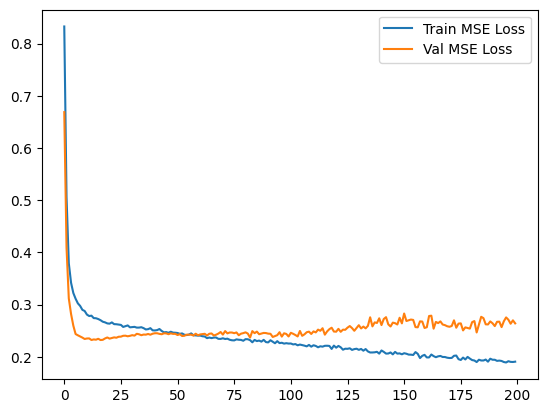

In [22]:
plt.plot(train_results["train_loss"], label="Train RMSE Loss")
plt.plot(train_results["val_loss"], label="Val RMSE Loss")
plt.legend()
plt.show()

In [23]:
preds = []
true_energies = []

hidden_state = model.init_hidden(128)
for embeddings, _, labels in val_loader:

    embeddings, labels = embeddings.cuda(), labels.cuda()  
    output, hidden_state = model(embeddings, hidden_state)
    preds.append(output.tolist())
    true_energies.append(labels.tolist())

preds = np.array(preds).flatten()
true_energies = np.array(true_energies).flatten()

RuntimeError: Expected hidden[0] size (2, 64, 77), got [2, 128, 77]

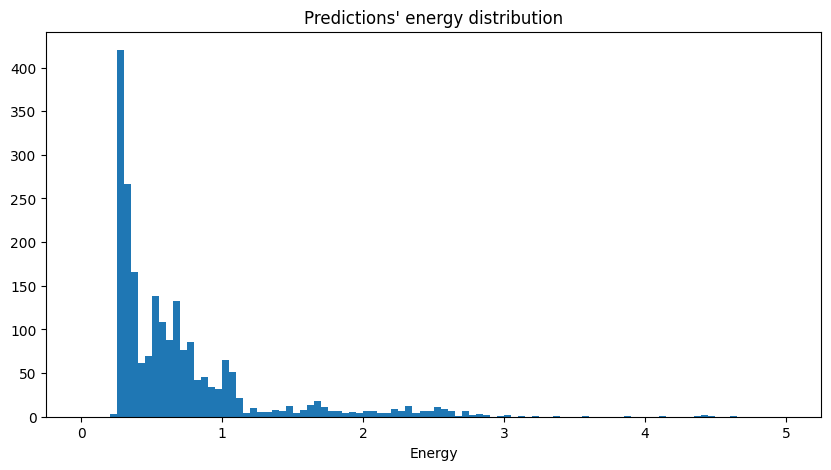

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

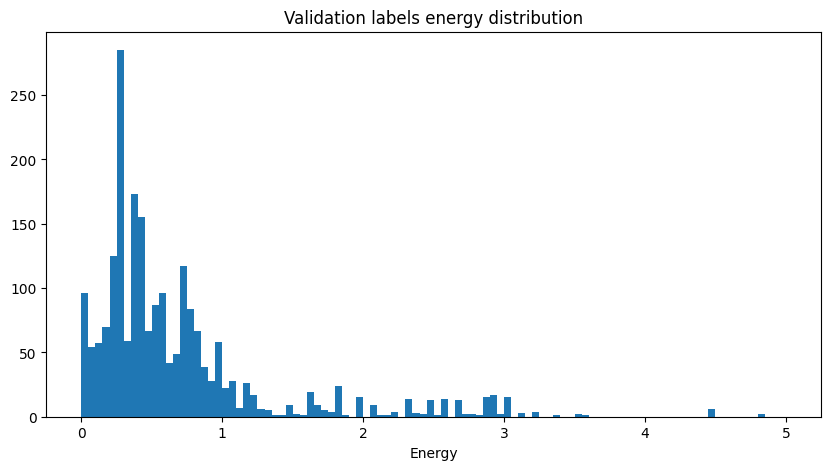

In [ ]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [ ]:
median = np.median(true_energies)
std = np.std(true_energies)

print(f"Labels' median: {median}, Labels' std: {std}")

Labels' median: 0.4756506511600576, Labels' std: 0.9399938859769091


In [ ]:
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

# Simple Model

In [26]:
class Simple_Regressor(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        layers: list[int],
        dropout: float = 0.15,
        regressor_dropout: float = 0.05,
    ) -> None:
        super().__init__()

        self.layers_list = []

        for i, dense in enumerate(layers):
            if i == 0:
                self.layers_list.append(nn.Linear(embedding_size, dense).cuda())
            else:
                self.layers_list.append(nn.Linear(layers[i - 1], dense).cuda())

        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(regressor_dropout)
        self.regressor = nn.Linear(layers[-1], 1)

    def forward(self, x):

        for dense in self.layers_list:
            x = dense(x)
            if dense == self.layers_list[-1]:
                x = self.dropout2(x)
            else:
                x = self.dropout(x)

        out = self.regressor(x)

        return out

## Training Function

In [27]:
def train_simple_model(
    model: Simple_Regressor,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float = 1e-2,
    batch_size: int = 32,
    epochs: int = 100,
    verbose: bool = False,
    early_stopping: bool = True,
    lr_decay: float=0.1,
    lr_decay_step: int=10,
) -> dict:

    if early_stopping:
        early_stopper = EarlyStopper(patience=15, min_delta=1e-4)

    criterion = nn.RMSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=lr_decay_step, gamma=lr_decay)
    
    model.cuda()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        losses = []
        for embeddings, labels in train_loader:

            embeddings = embeddings.cuda()
            labels = labels.cuda()

            output = model(embeddings)
            #We use RRMSE Loss
            loss = torch.sqrt(criterion(output.squeeze(), labels.float()) + 1e-8)


            optimizer.zero_grad()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            losses.append(loss.item())

        val_loss = []
        model.eval()
        for embeddings, labels in val_loader:

            embeddings, labels = embeddings.cuda(), labels.cuda()
            output = model(embeddings)
            #We use RRMSE Loss
            v_loss = torch.sqrt(criterion(output.squeeze(), labels.float()) + 1e-8)


            val_loss.append(v_loss.item())

        if verbose:
            print(
                f"Epoch: {epoch+1}/{epochs}, RMSE Train Loss: {round(np.mean(losses), 5)}, RMSE Val Loss: {round(np.mean(val_loss), 5)}"
            )

        train_losses.append(np.mean(losses))
        val_losses.append(np.mean(val_loss))

        if early_stopping:
            if early_stopper.early_stop(val_losses[-1]):
                break

        scheduler.step()

    model_training = {
        "model": model,
        "train_loss": train_losses,
        "val_loss": val_losses,
        "epochs_trained": epoch,
    }

    return model_training


## Optuna Trials

In [28]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "simple_nn-mean_emb-regression-study-good-dataset"
storage_name = f"sqlite:////Users/thodo/Documents/σχολη/diplomatiki/optuna-studies/simple_nn-mean_emb-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RRMSE")

[I 2023-01-11 02:08:48,410] Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.


Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.
Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.
Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.
Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.


In [12]:
def objective(trial):

    num_layers = trial.suggest_int("dense_layers", 1, 6)
    dense_layers = [trial.suggest_int(f"dense_{i}", 8, 256) for i in range(num_layers)]
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lr = trial.suggest_float("lr", 1e-4, 1e-2)
    lr_decay = trial.suggest_float("lr_decay", 0.05, 0.8)
    lr_decay_step = trial.suggest_int("lr_decay_step", 5, 20)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    regressor_dropout = trial.suggest_float("regressor_dropout", 0, 0.15)

    batch_size = 2**batch_size_exp

    data_loaders = get_data_dict(data_df=data_df, mean=True, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = Simple_Regressor(
        embedding_size=embedding_size,
        layers=dense_layers,
        dropout=dropout,
        regressor_dropout=regressor_dropout,
    )

    train_results = train_simple_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
        lr_decay=lr_decay,
        lr_decay_step=lr_decay_step,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=120)

[I 2023-01-09 14:08:28,492] Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.


Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.
Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.


In [29]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_dense_0,params_dense_1,params_dense_2,params_dense_3,params_dense_4,params_dense_5,params_dense_layers,params_dropout,params_learning_rate_exp,params_regressor_dropout,state
55,55,0.439975,2023-01-09 06:17:46.434492,2023-01-09 06:30:07.847971,0 days 00:12:21.413479,3,162,NaN,NaN,NaN,NaN,NaN,1,0.184660,-3,0.000839,COMPLETE
77,77,0.481107,2023-01-09 09:51:28.306257,2023-01-09 09:57:56.392646,0 days 00:06:28.086389,4,203,NaN,NaN,NaN,NaN,NaN,1,0.153568,-3,0.017584,COMPLETE
60,60,0.483190,2023-01-09 07:21:23.597985,2023-01-09 07:27:57.998985,0 days 00:06:34.401000,4,176,NaN,NaN,NaN,NaN,NaN,1,0.172506,-3,0.006142,COMPLETE
63,63,0.493283,2023-01-09 07:48:39.618658,2023-01-09 08:01:33.299750,0 days 00:12:53.681092,3,137,NaN,NaN,NaN,NaN,NaN,1,0.058225,-3,0.003660,COMPLETE
37,37,0.511997,2023-01-09 04:05:56.400867,2023-01-09 04:09:12.563638,0 days 00:03:16.162771,5,235,NaN,NaN,NaN,NaN,NaN,1,0.167221,-3,0.140379,COMPLETE
48,48,0.532418,2023-01-09 04:48:09.741557,2023-01-09 05:00:30.477013,0 days 00:12:20.735456,3,158,NaN,NaN,NaN,NaN,NaN,1,0.189842,-3,0.019822,COMPLETE
22,22,0.532783,2023-01-09 03:07:39.123335,2023-01-09 03:10:55.686098,0 days 00:03:16.562763,5,221,NaN,NaN,NaN,NaN,NaN,1,0.173118,-3,0.121949,COMPLETE
47,47,0.540323,2023-01-09 04:41:54.784896,2023-01-09 04:48:09.722564,0 days 00:06:14.937668,4,160,NaN,NaN,NaN,NaN,NaN,1,0.153256,-3,0.134953,COMPLETE
92,92,0.541284,2023-01-09 11:48:51.572990,2023-01-09 12:02:42.010988,0 days 00:13:50.437998,3,60,NaN,NaN,NaN,NaN,NaN,1,0.151706,-3,0.132688,COMPLETE
64,64,0.541902,2023-01-09 08:01:33.318743,2023-01-09 08:07:45.494753,0 days 00:06:12.176010,4,112,NaN,NaN,NaN,NaN,NaN,1,0.044553,-3,0.000672,COMPLETE


In [30]:
print(f"Best simple-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best simple-regressor-model params: {'batch_size_exp': 3, 'dense_0': 162, 'dense_layers': 1, 'dropout': 0.18466029305173945, 'learning_rate_exp': -3, 'regressor_dropout': 0.0008387692491181251}, achieving val MSE: 0.43997468536312434


## Results

In [2]:
load = False
save = True

batch_size = 2**3

data_loaders = get_data_dict(data_df=data_df, mean=True, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = Simple_Regressor(
    embedding_size=embedding_size, layers=[162], regressor_dropout=8e-4
)

if load:
    model.load_state_dict(torch.load("../../model_checkpoints/simple_model"))
else:
    train_results = train_simple_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=10e-3,
        epochs=200,
        batch_size=batch_size,
        verbose=True,
        early_stopping=True,
        lr_decay=0.1,
        lr_decay_step=10,
    )
    if save:
        torch.save(model.state_dict(), "../../model_checkpoints/simple_model")

NameError: name 'get_data_dict' is not defined

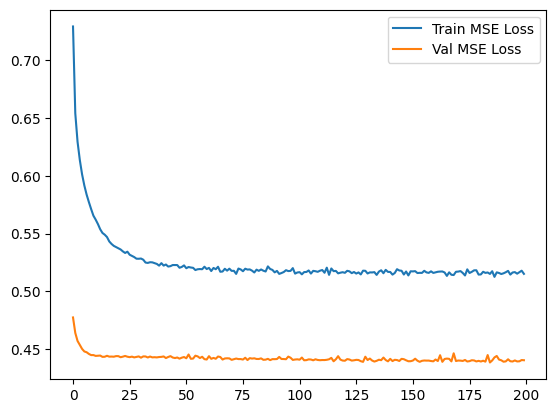

In [ ]:
plt.plot(train_results["train_loss"], label="Train RMSE Loss")
plt.plot(train_results["val_loss"], label="Val RMSE Loss")
plt.legend()
plt.show()

In [ ]:
preds = []
true_energies = []

for embeddings, labels in val_loader:

    embeddings, labels = embeddings.cuda(), labels.cuda()  
    output = model(embeddings)
    preds.append(output.tolist())
    true_energies.append(labels.tolist())

preds = np.array(preds).flatten()
true_energies = np.array(true_energies).flatten()

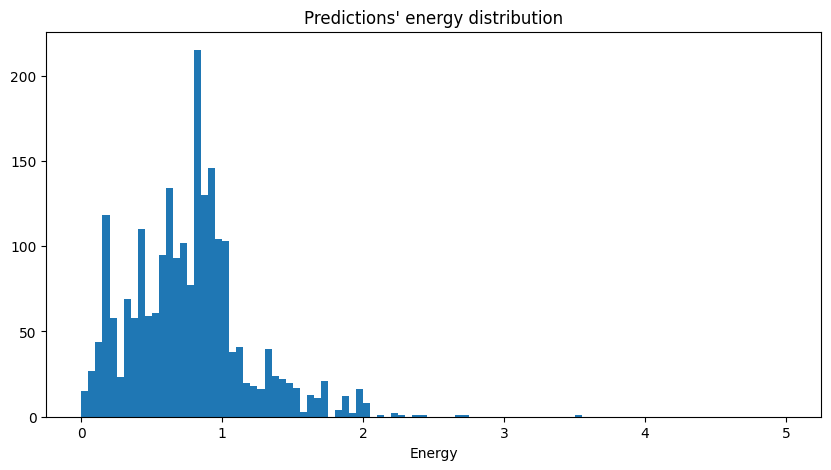

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

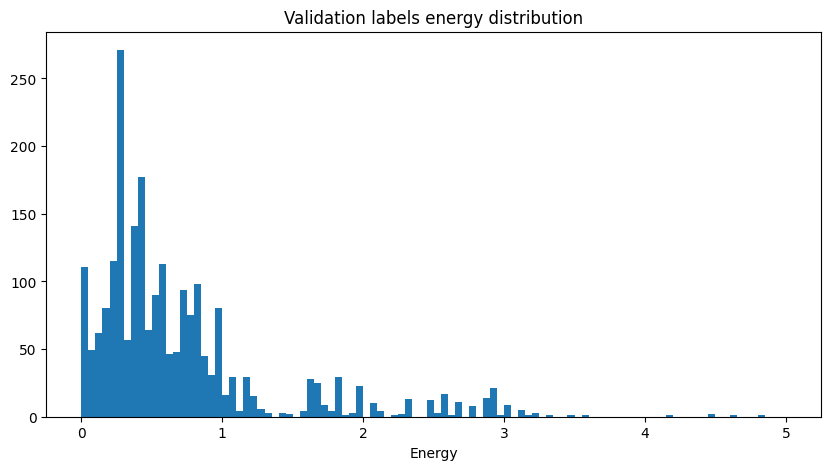

In [ ]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [ ]:
median = np.median(true_energies)
std = np.std(true_energies)

print(f"Labels' median: {median}, Labels' std: {std}")

In [ ]:
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()